Attempt to implement entire PINN.

Import Statements

In [25]:
import os
import torch
import torchvision
from torch import nn 
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset
import pyDOE2
from mpl_toolkits.mplot3d import Axes3D

Some Variables

In [26]:
n = 200 #num data points
n_collocation = 10000
t_0_prop = 0.5

Data Generation

In [27]:
np.random.seed(0)

#boundary data proportions
t_0_n = (int)(n * t_0_prop)
x_1_n = (n - t_0_n) // 2
x_neg_1_n = n - t_0_n - x_1_n

#generating t = 0 data points with -1 \leq x \leq 1
t_0_values = np.random.rand(t_0_n) * 2 - 1
t_0_values = np.column_stack((np.zeros(t_0_n), t_0_values)) #Add a second t dimension that is always 0 (of form t,x)

#labels of sin(\pi * x) for each x. Generating t = 0 labels
t_0_label_values = -np.sin(t_0_values[:, 1] * np.pi)

#generating x = 1 and x = -1 data points with 0 \leq t \leq 1
x_1_values = np.ones(x_1_n)
x_neg_1_values = np.ones(x_neg_1_n) * -1
x_1_neg_1_values = np.hstack((x_1_values, x_neg_1_values))
x_1_neg_1_values = np.column_stack((np.random.rand(x_1_n + x_neg_1_n), x_1_neg_1_values))

#label values for x = 1 and x = -1 boundary points
x_1_neg_1_label_values = np.zeros(x_1_n + x_neg_1_n)

#concating into input and label arrays
input_values = np.vstack((t_0_values, x_1_neg_1_values))
label_values = np.hstack((t_0_label_values, x_1_neg_1_label_values))


Collocation Point Generation

In [28]:
def lhs_samples(n_collocation): #generate n_collocation points via Latin Hypercube Sampling. Each point is a (t,x)
    lhs_array = pyDOE2.lhs(2, samples=n_collocation) #Two dimensions. Values from 0 to 1
    lhs_array[:,1] = 2*lhs_array[:,1] - 1 #convert range of x values to -1 to 1
    return lhs_array

collocation_points = lhs_samples(n_collocation)

Neural Network

In [29]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_func = nn.Tanh()
        self.predict = nn.Sequential(
            nn.Linear(2, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 1)
        )

    def forward(self, x):
        x = self.predict(x)
        return x


PINN Loss

In [30]:
def MSE_f(network, collocation_t, collocation_x):

    u = network(torch.cat((collocation_t, collocation_x), dim=1))

    u_t = torch.autograd.grad(u, collocation_t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, collocation_x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, collocation_x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

    return torch.mean((u_t + u*u_x - (0.01/torch.pi)*u_xx)**2)
    

    

def criterion(output, labels, network, collocation_t, collocation_x):
    loss_u = nn.MSELoss()(output, labels)
    loss_f = MSE_f(network, collocation_t, collocation_x)
    overall_loss = loss_u + loss_f
    return overall_loss, loss_u, loss_f

Model Training Parameters

In [31]:
network = Network()
optimizer = torch.optim.LBFGS(network.parameters(), #PARAMETERS CREDIT TO https://github.com/teeratornk/PINNs-2/blob/master/Burgers%20Equation/Burgers%20Inference%20(PyTorch).ipynb
                              lr=1,
                              max_iter=50000, 
                                max_eval=50000, 
                                history_size=50,
                                tolerance_grad=1e-5, 
                                tolerance_change=1.0 * np.finfo(float).eps,
                                line_search_fn="strong_wolfe"
                              )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + ("GPU" if torch.cuda.is_available() else "CPU"))
network.to(device)

input_data = torch.tensor(input_values.astype(np.float32)).to(device).view(-1, 2) # "view" is technically unnecessary as tensor already has shappe [n,2]
label_data = torch.tensor(label_values.astype(np.float32)).to(device).view(-1, 1)
collocation_t = torch.tensor(collocation_points[:,0].astype(np.float32), requires_grad=True).to(device).view(-1, 1)
collocation_x = torch.tensor(collocation_points[:,1].astype(np.float32), requires_grad=True).to(device).view(-1, 1)

Using device: CPU


Model Training

In [32]:
i = 0

def closure():
    optimizer.zero_grad() #reset the gradient so that the previous iteration does not affect the current one
    output = network(input_data) #run the batch through the current model
    overall_loss, loss_u, loss_f = criterion(output, label_data, network, collocation_t, collocation_x) #calculate the loss
    overall_loss.backward() #Using backpropagation, calculate the gradients
    #print(f"Avg loss: {loss.item()}")

    global i
    if i%100 == 0:
        print(f"STEP: {i} | Avg Losses | MSE_u: {loss_u.item()} | MSE_f: {loss_f.item()} | Total: {overall_loss.item()}")
    i += 1

    return overall_loss

optimizer.step(closure) #Using the gradients, adjust the parameters   

STEP: 0 | Avg Losses | MSE_u: 0.32406318187713623 | MSE_f: 8.239804856202682e-07 | Total: 0.3240640163421631
STEP: 100 | Avg Losses | MSE_u: 0.08948541432619095 | MSE_f: 0.007790562231093645 | Total: 0.0972759798169136
STEP: 200 | Avg Losses | MSE_u: 0.02752036415040493 | MSE_f: 0.008793679997324944 | Total: 0.036314044147729874
STEP: 300 | Avg Losses | MSE_u: 0.020046303048729897 | MSE_f: 0.004189522936940193 | Total: 0.02423582598567009
STEP: 400 | Avg Losses | MSE_u: 0.01597541570663452 | MSE_f: 0.0044927229173481464 | Total: 0.02046813815832138
STEP: 500 | Avg Losses | MSE_u: 0.009645088575780392 | MSE_f: 0.005044329911470413 | Total: 0.014689418487250805
STEP: 600 | Avg Losses | MSE_u: 0.004022653214633465 | MSE_f: 0.00384897761978209 | Total: 0.007871630601584911
STEP: 700 | Avg Losses | MSE_u: 0.0022780734580010176 | MSE_f: 0.002586528891697526 | Total: 0.0048646023496985435
STEP: 800 | Avg Losses | MSE_u: 0.0018273532623425126 | MSE_f: 0.0019142673118039966 | Total: 0.003741620

tensor(0.3241, grad_fn=<AddBackward0>)

2d Graphing at t = 0 of Random Points and Predictions

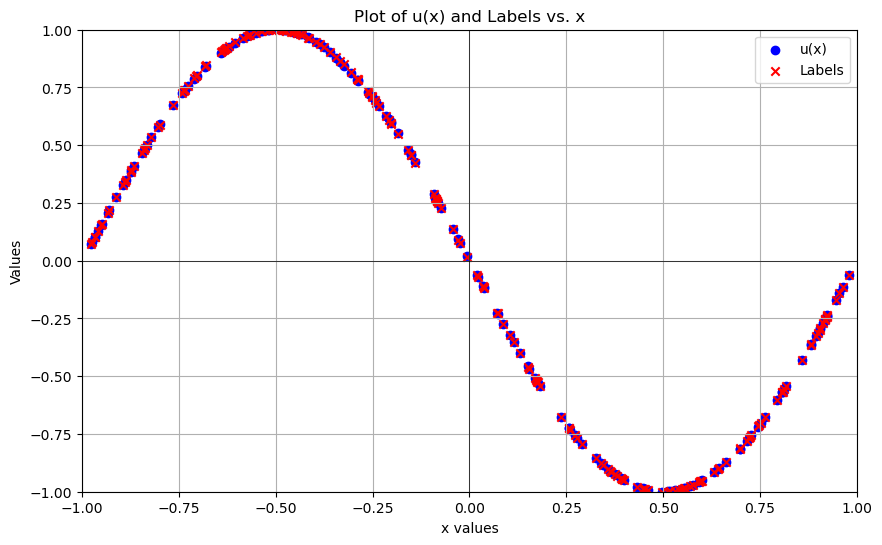

In [33]:
test_n = n

test_input_values = np.random.rand(test_n) * 2 - 1
test_input_values = np.column_stack((np.zeros(test_n), test_input_values)) #Add a second t dimension that is always 0

#labels of sin(\pi * x) for each x in Say
test_label_values = -np.sin(test_input_values[:, 1] * np.pi)


def plot_tensors(x, u, labels):
    # Convert tensors to numpy arrays
    x_np = x
    u_np = u

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_np, u_np, color='blue', marker='o', label='u(x)')
    
    if labels is not None:
        labels_np = labels
        plt.scatter(x_np, labels_np, color='red', marker='x', label='Labels')
    
    plt.title('Plot of u(x) and Labels vs. x')
    plt.xlabel('x values')
    plt.ylabel('Values')
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.legend()
    plt.show()

x = test_input_values[:, 1]
u = network(torch.Tensor(test_input_values.astype(np.float32)).view(-1,2)).detach().numpy()


plot_tensors(x, u, test_label_values)

Heatmap for -1 \leq x \leq 1 and 0 \leq t \leq 1

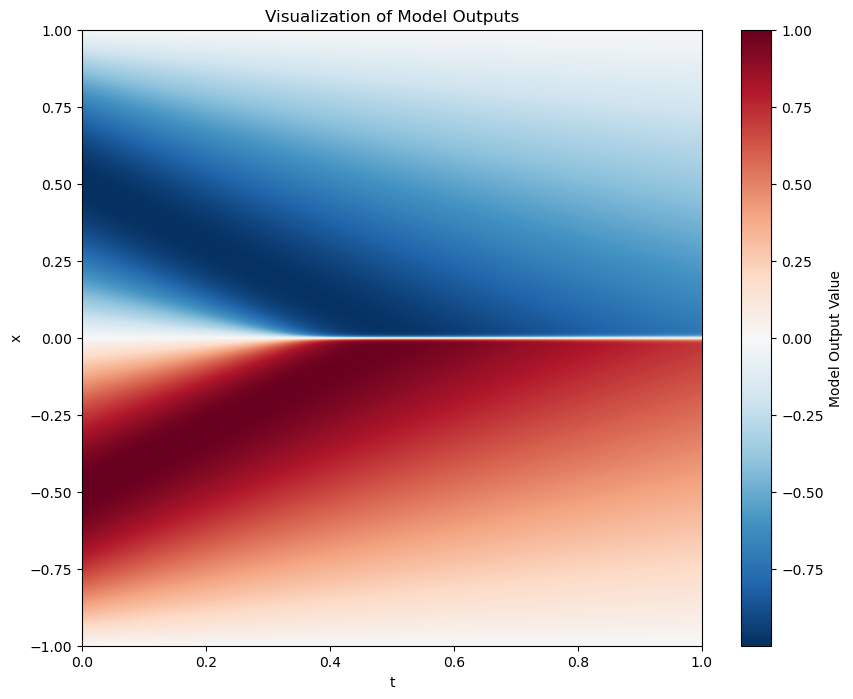

In [39]:
map_density = 2000

# Generate a dense grid of values for t and x
t_grid = np.linspace(0, 1, map_density)  # Adjust the density as needed
x_grid = np.linspace(-1, 1, map_density)
t_values, x_values = np.meshgrid(t_grid, x_grid)

points = np.vstack((t_values.ravel(), x_values.ravel())).T
points_tensor = torch.tensor(points, dtype=torch.float32).to(device)

# Feed the Points through the Model
with torch.no_grad():
    model_outputs = network(points_tensor).cpu().numpy()
model_outputs_reshaped = model_outputs.reshape(t_values.shape)

# Plotting using a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(model_outputs_reshaped, extent=[0, 1, -1, 1], origin='lower', cmap='RdBu_r', aspect='auto')
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(label='Model Output Value')
plt.title("Visualization of Model Outputs")
plt.show()


3d Plot

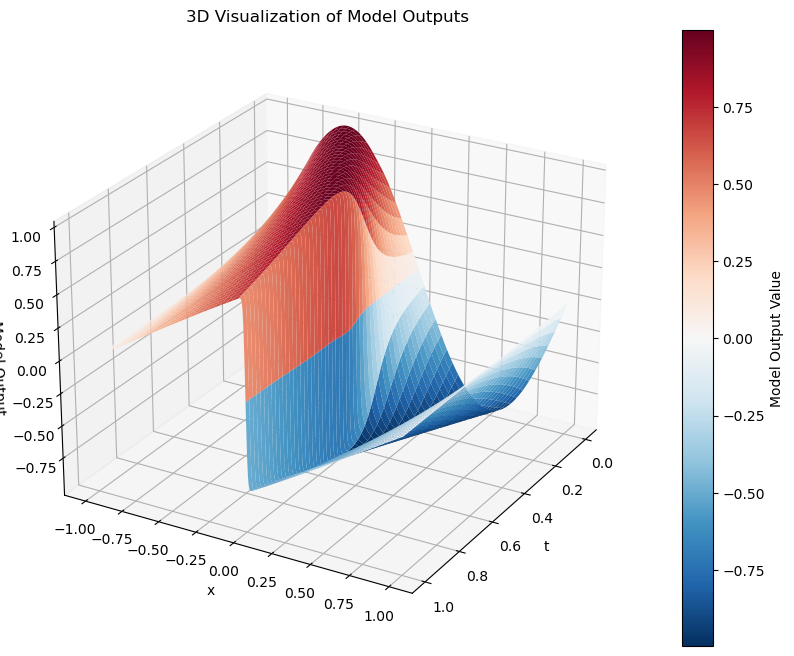

In [41]:
# Set up the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot using a 3D surface plot
surf = ax.plot_surface(t_values, x_values, model_outputs_reshaped, cmap='RdBu_r', edgecolor='none')

# Set the labels and title
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_zlabel("Model Output")
ax.set_title("3D Visualization of Model Outputs")

# Add a color bar on the right side of the plot
fig.colorbar(surf, ax=ax, label='Model Output Value')

#Modify perspective
ax.view_init(elev=25, azim=30)


# Display the plot
plt.show()

SAVING MODEL

In [37]:
toSave = True

if toSave:
    base_path = "./"
    base_name = "pinn_model_new"
    extension = ".pth"

    counter = 0
    model_save_path = os.path.join(base_path, base_name + extension)

    while os.path.exists(model_save_path):
        counter += 1
        model_save_path = os.path.join(base_path, f"{base_name}_{counter}{extension}")

    torch.save(network.state_dict(), model_save_path)

    print("Model saved!")

Model saved!
